In [ ]:
# Imports
import joblib
from typing import Union, List

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,  KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [2]:
# To handle warnings
import warnings
warnings.filterwarnings("ignore")

seed = 21

In [ ]:
# Load Data
raw_df = pd.read_csv("sds_assessment/data/GermanCredit.csv")

### 1. Data Exploration and Preprocessing

In [4]:
# Initial look at data shape and a few columns
print(f"Shape: {raw_df.shape}")
raw_df.head()

Shape: (1000, 23)


,Unnamed: 0,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,...,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job,gender
0,0,-43.0,6,critical,radio/tv,1169,NaN,13 years,4,single,...,67,none,own,2,0,1,2.349340e+09,yes,skilled employee,male
1,1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,NaN,...,22,none,own,1,1,1,NaN,yes,skilled employee,female
2,2,NaN,12,critical,education,2096,24.0,5 years,2,single,...,49,none,own,1,0,2,NaN,yes,unskilled resident,male
3,3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,...,45,none,for free,1,0,2,NaN,yes,skilled employee,male
4,4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,...,53,none,for free,2,1,2,NaN,yes,skilled employee,male


In [5]:
# 4. Basic Data Summary
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1000 non-null   int64  
 1   checking_balance      606 non-null    float64
 2   months_loan_duration  1000 non-null   int64  
 3   credit_history        1000 non-null   object 
 4   purpose               1000 non-null   object 
 5   amount                1000 non-null   int64  
 6   savings_balance       817 non-null    float64
 7   employment_length     938 non-null    object 
 8   installment_rate      1000 non-null   int64  
 9   personal_status       690 non-null    object 
 10  other_debtors         1000 non-null   object 
 11  residence_history     870 non-null    object 
 12  property              1000 non-null   object 
 13  age                   1000 non-null   int64  
 14  installment_plan      1000 non-null   object 
 15  housing               

 The data has a 1000 rows with 23 columns/features with 12 categorical variables and 11 continous variables(including `Unnamed: 0` and `default`). Also there are varying amounts of missing data across certain features - ‘checking_balance’, ‘savings_balance’, ‘employment_length’, ‘personal_stat.us’, ‘residency_history’ and ‘telephone’

I can see missing values across `checking_balance`, `savings_balance`, `employment_length`, `personal_status`, `residence_history`, and `telephone`. Decision on how each would be handled will depend on findings during further exploration and visualization.


In [6]:
# Remove the first column as it is an index and would not be useful in modelling
raw_df.drop(columns=["Unnamed: 0"], inplace=True)
# identify target column
target = 'default' 

-  `Unnamed: 0` will be dropped as it is an index.

#### 1.2 Visualization of features/columns to better understand the data

📊 Distribution of Target class, 'default'


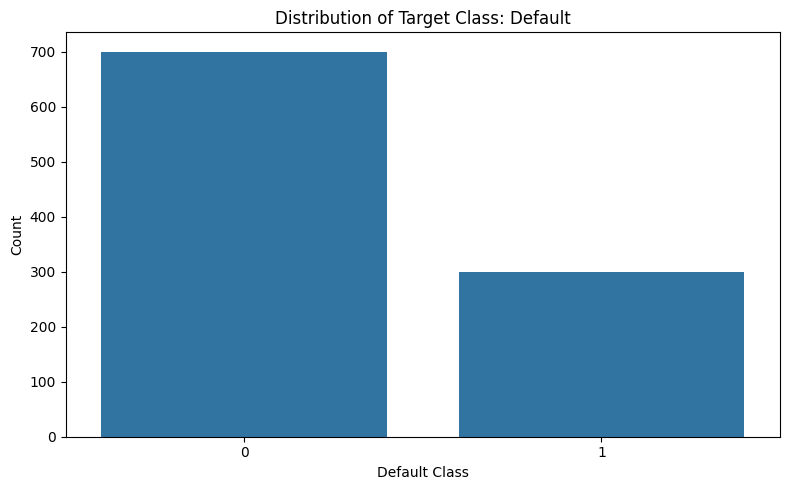

In [29]:
print("📊 Distribution of Target class, 'default'")
plt.figure(figsize=(8, 5))
sns.countplot(x=target, data=raw_df, order=sorted(raw_df[target].unique()))
plt.xlabel('Default Class')
plt.ylabel('Count')
plt.title('Distribution of Target Class: Default')
plt.tight_layout()
plt.show()

Based on the information in the accompanying pdf, `default` should have two classes - `1` indicating good loans, and `2` indicating default. However this is not the case and as such it would require no further processing.

In [8]:
numeric_cols = raw_df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop("default")
categorical_cols = raw_df.select_dtypes(include=['object']).columns

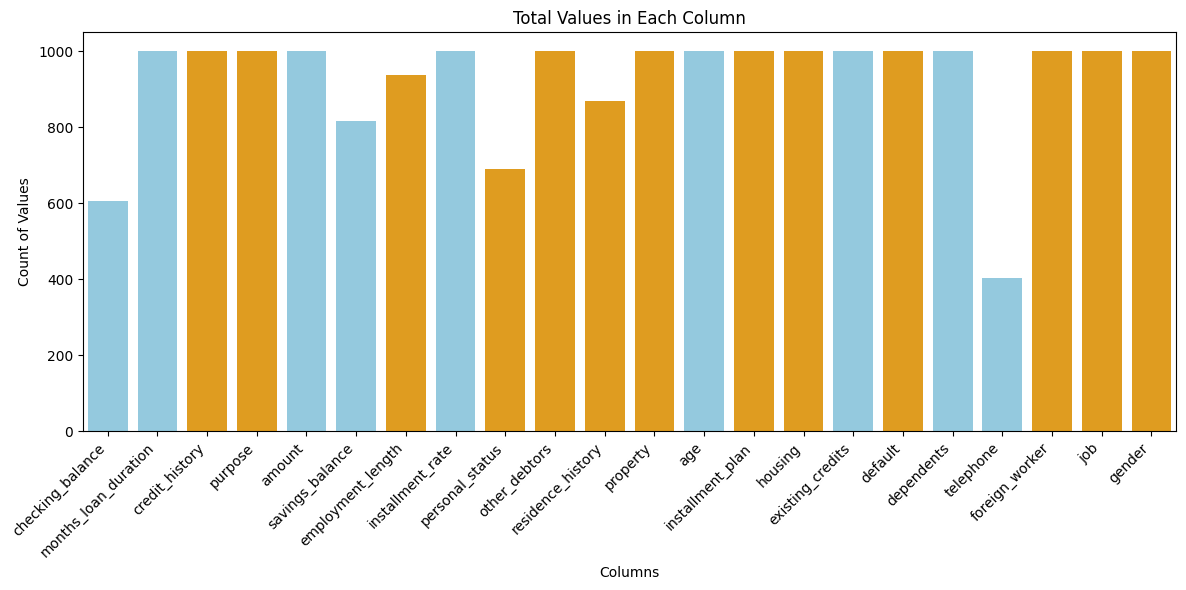

In [28]:
# Count non-missing values in each column
non_missing_values = raw_df.notnull().sum()

# Create a color map: Blue for numerical, Orange for categorical
colors = ['skyblue' if col in numeric_cols else 'orange' for col in raw_df.columns]

# visualise missing values
plt.figure(figsize=(12, 6))  
sns.barplot(x=raw_df.columns, y=non_missing_values, palette=colors)

# Rotate x-axis labels for better spacing
plt.xticks(rotation=45, ha='right')

# Add title and labels
plt.title('Total Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count of Values')

# Adjust layout to prevent label clipping
plt.tight_layout()

plt.show()

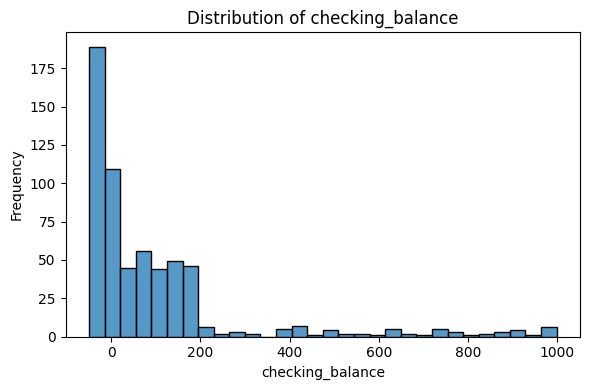

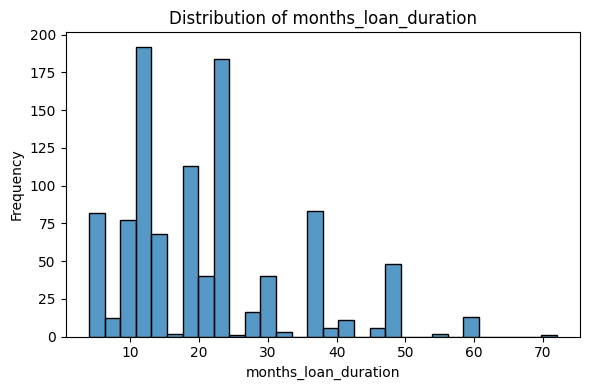

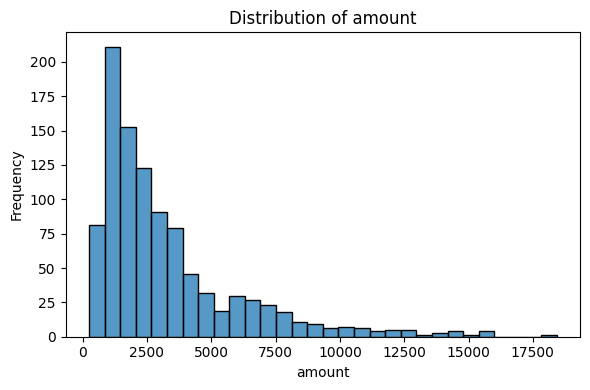

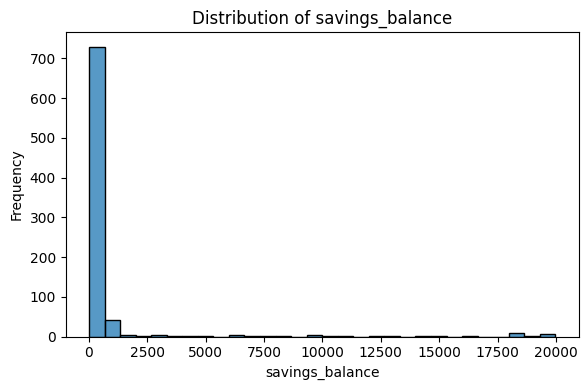

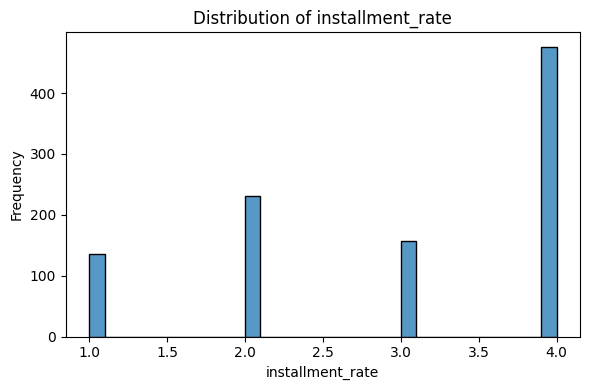

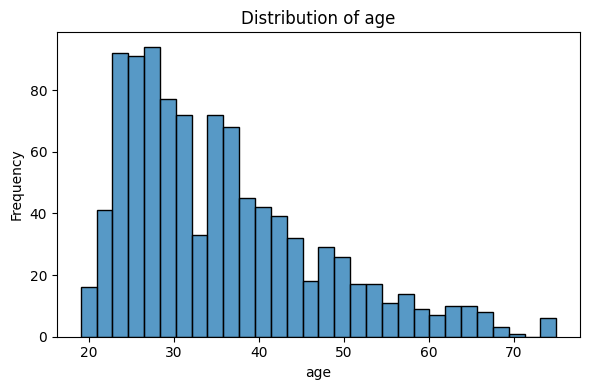

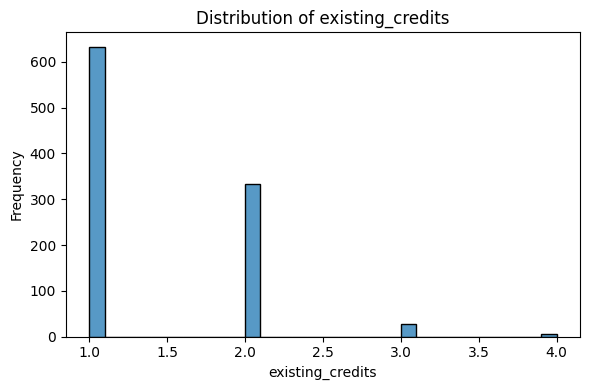

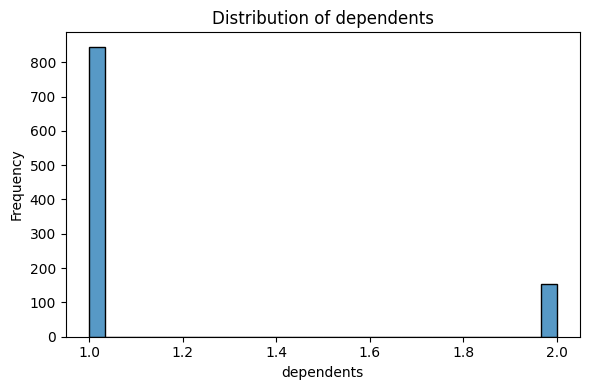

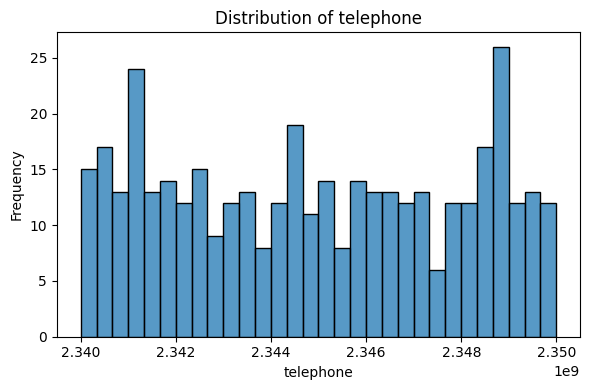

In [10]:
# Histograms for numeric columns to better appreciate distributions in the dataset
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=raw_df, x=col, bins=30, kde=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

- The `telephone` column is incorrectly treated as a numerical feature due to its numeric format, but it represents personally identifiable information. To avoid using unique identifiers in model training and preserve user privacy, I will not include the actual phone numbers. Instead, I will encode the presence of a phone number as a binary feature called `has_phone`, indicating whether or not a phone number is provided. This retains useful information (e.g., traceability or user verification potential) without compromising privacy.

- Other numerical columns hold skewed distributions which may be normalized during preprocessing.

📊 Count Plots for Categorical Columns:


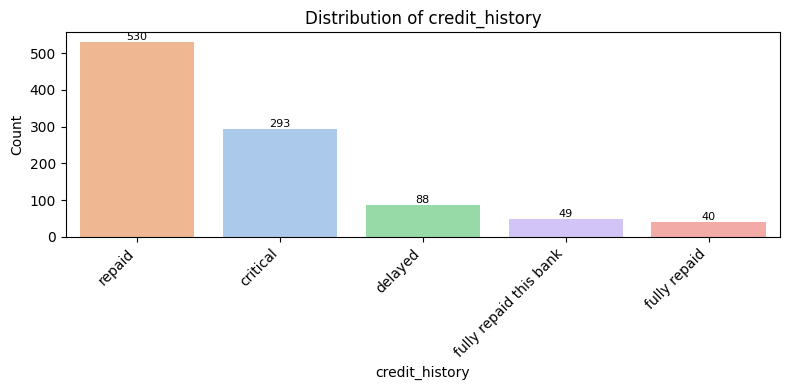

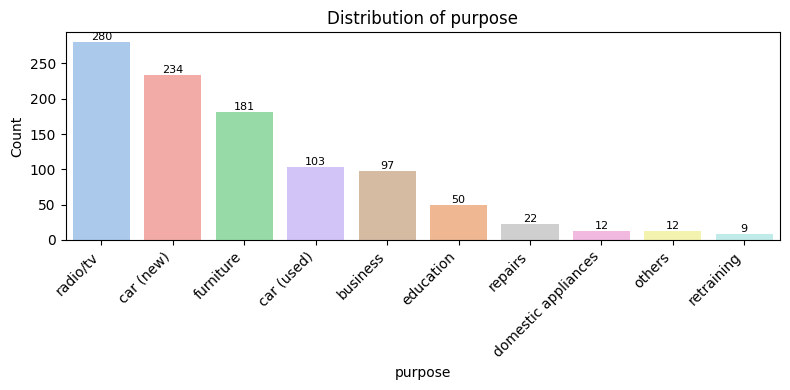

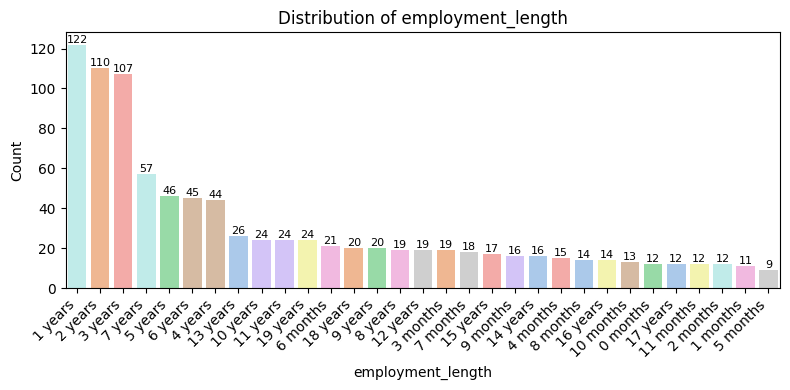

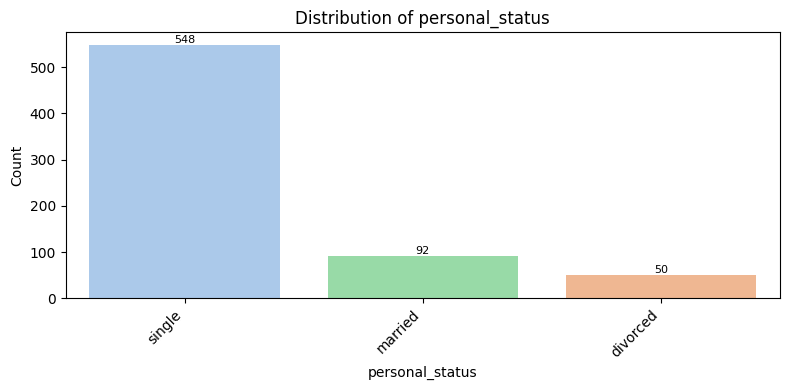

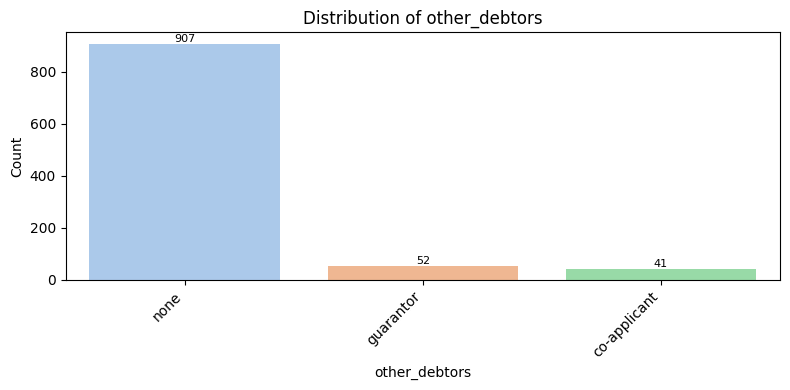

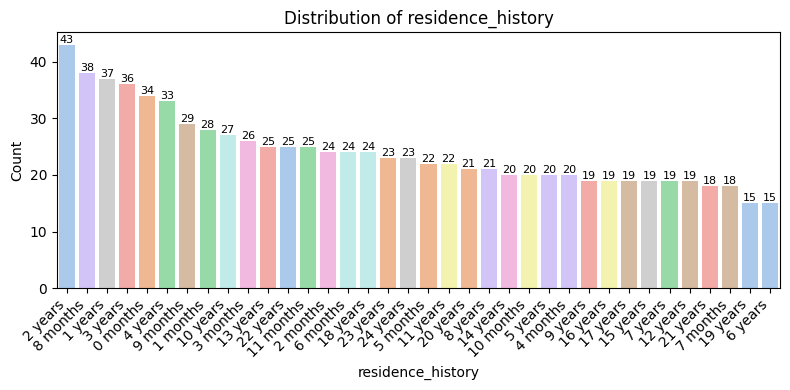

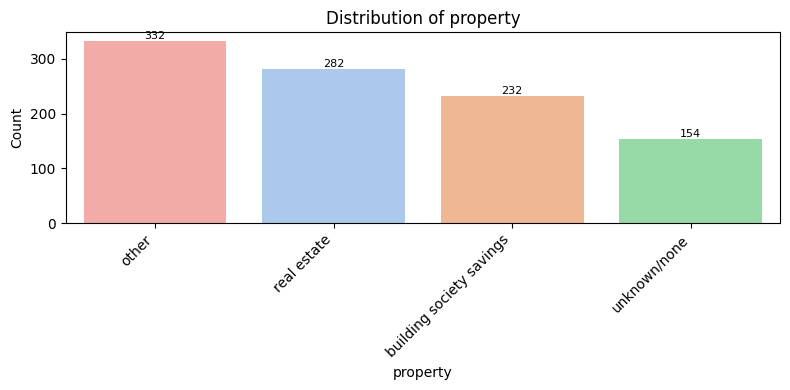

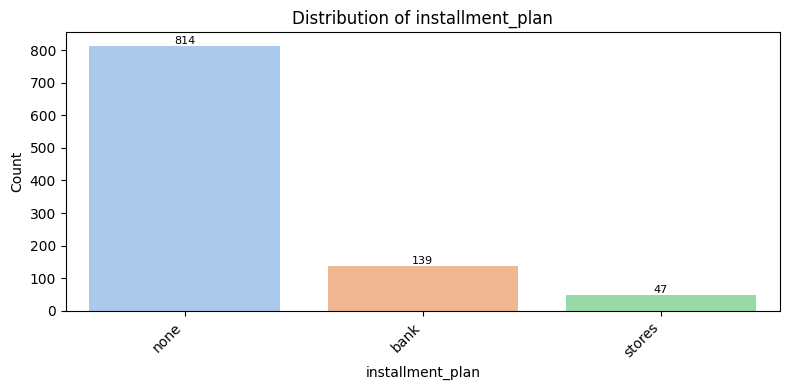

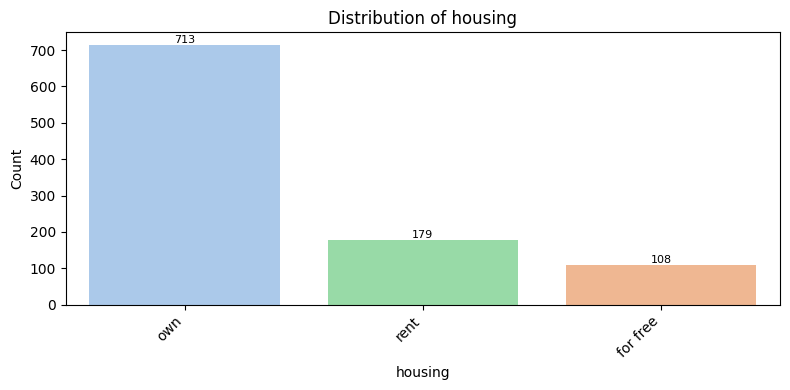

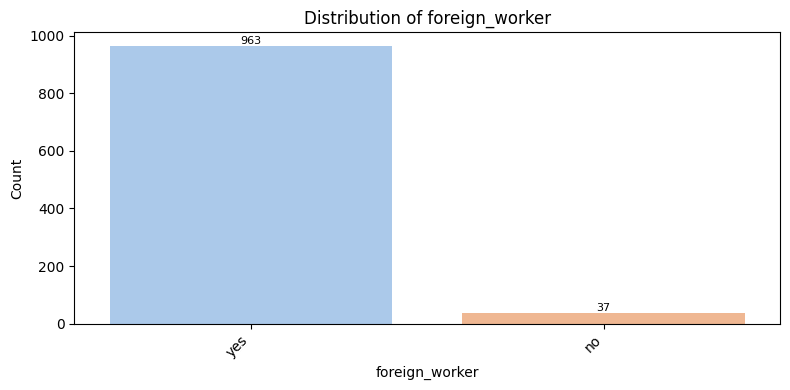

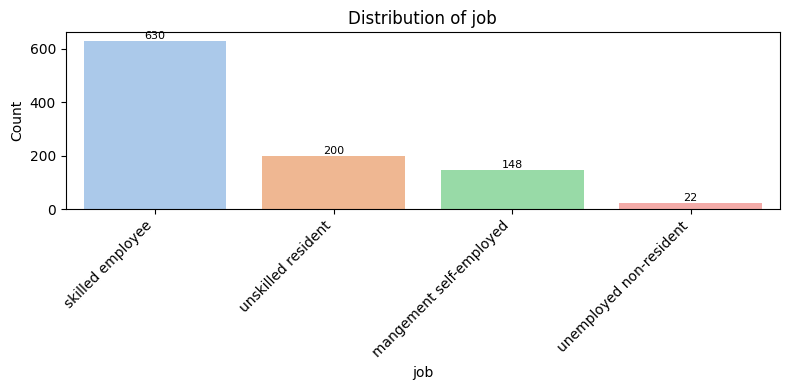

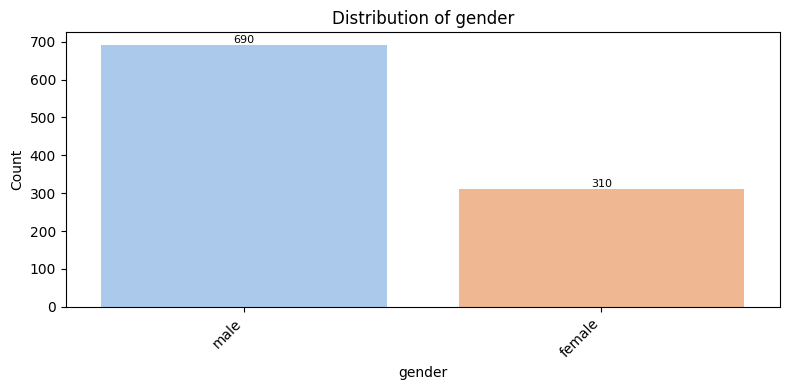

In [11]:
# Bar plots for categorical columns, to similarly understand the data
print("📊 Count Plots for Categorical Columns:")
for col in categorical_cols:
    plt.figure(figsize=(8, 4))

    # Use unique colours for each category
    ax = sns.countplot(
        x=col,
        hue=col,
        data=raw_df,
        order=raw_df[col].value_counts().index,
        palette="pastel",
        legend=False
    )

    # Add count labels
    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f'{count}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Count", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

- At a glance, few applicants have `other_debtors`(0.09%) or use an `installment_plan` (0.18%)
- `residence_history` and `employment_length` should be numerical columns, but due to how it was collected it is currently a categorical column and would not allow the model to extract reasonable information. I will modify this in preprocessing to a numerical column
- The Categorical columns have some imbalanced ditribution which may result in compromised model performances in certain instances.
For instance:
    - Only 37(~ 0.04%) entries are not `foreign_worker`s
    - Similarly only 22 (0.02%) entries are `unemployed non resident` in the `job` column

In [12]:
# I exlcude 'residence_history', 'employment_length' from the next step as they are not true categorical columns
categorical_cols.drop(['residence_history', 'employment_length'])

Index(['credit_history', 'purpose', 'personal_status', 'other_debtors',
       'property', 'installment_plan', 'housing', 'foreign_worker', 'job',
       'gender'],
      dtype='object')

📊 Categorical Variables vs Default:


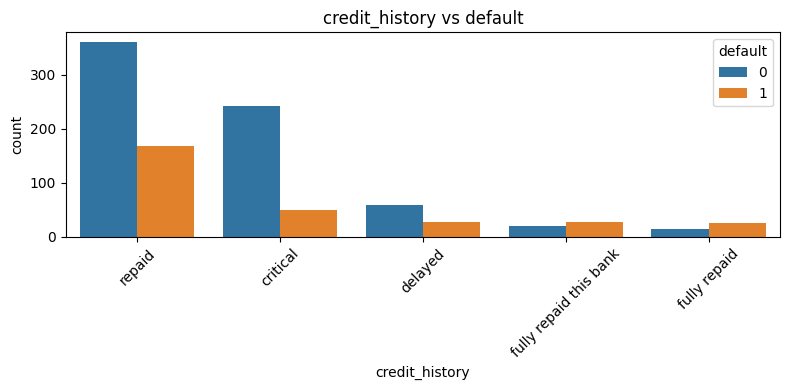

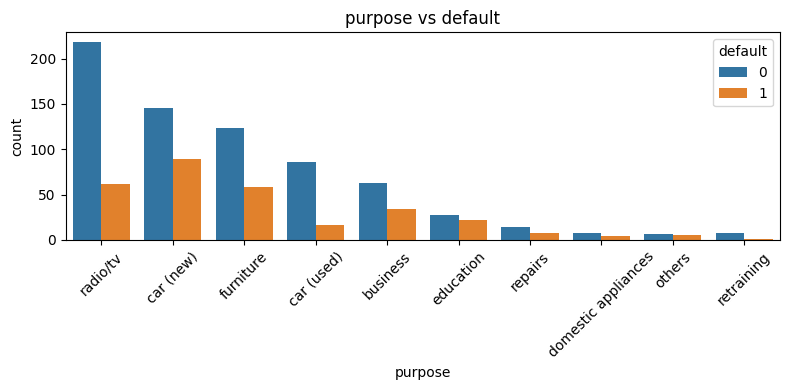

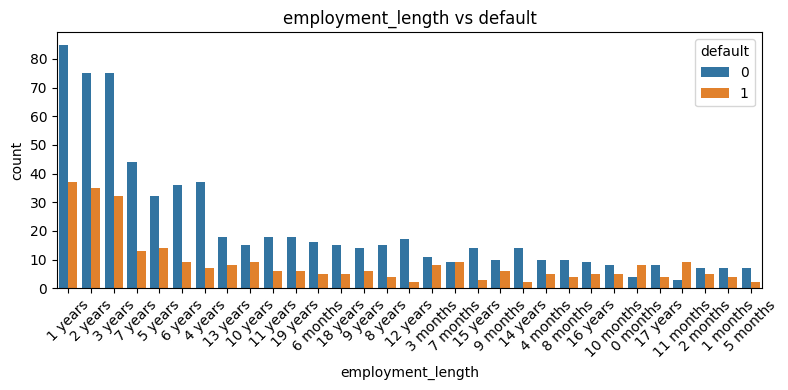

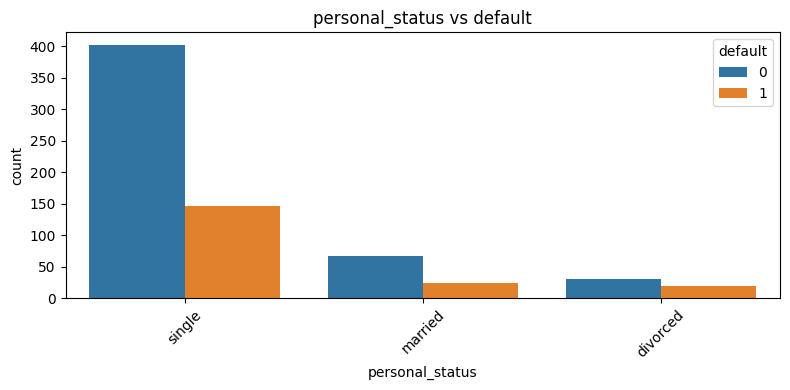

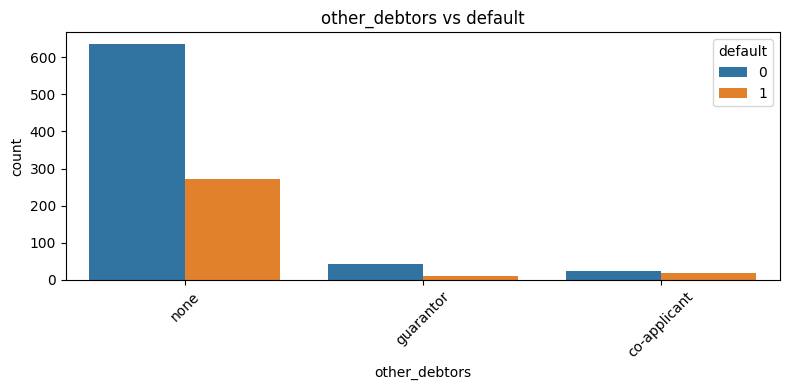

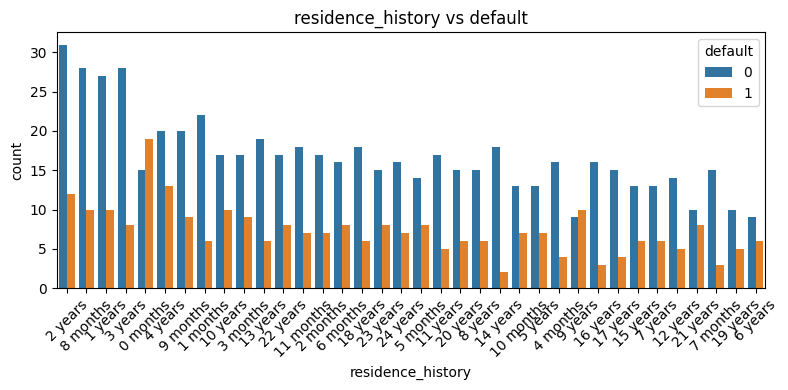

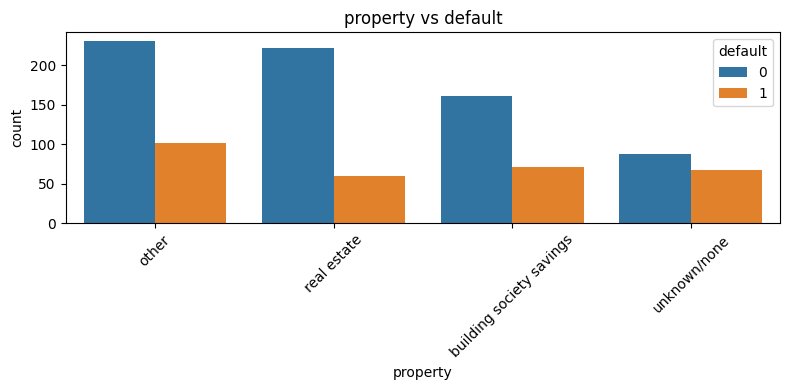

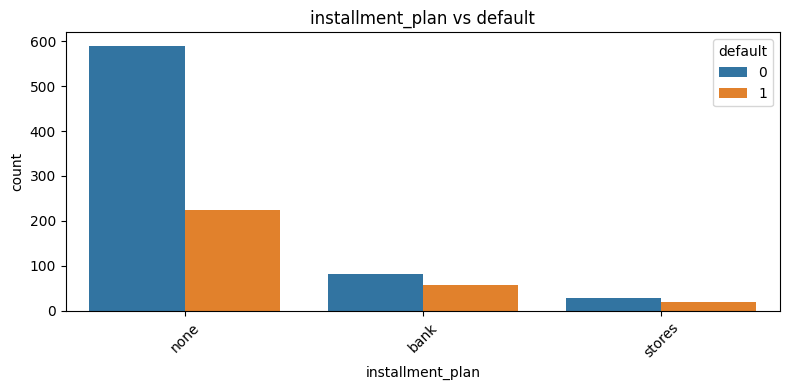

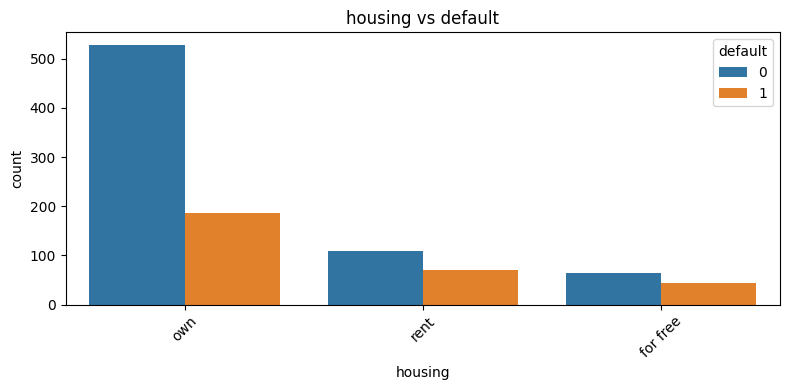

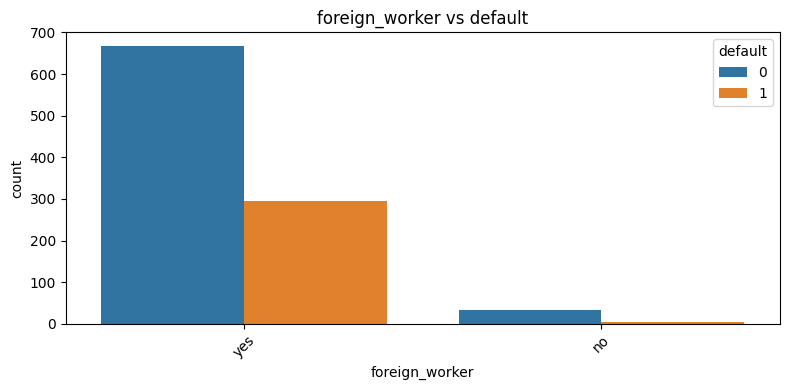

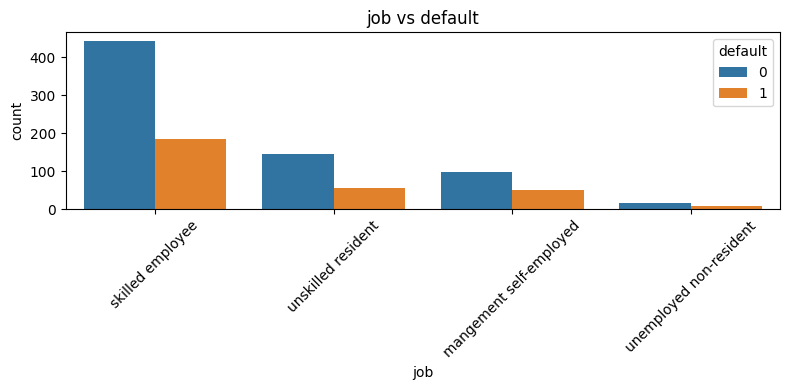

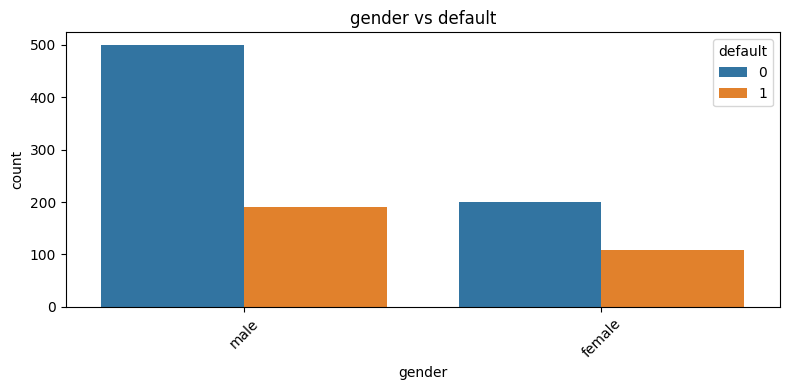

In [13]:
# Categorical vs Target
print("📊 Categorical Variables vs Default:")
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue=target, data=raw_df, order=raw_df[col].value_counts().index)
    plt.title(f'{col} vs {target}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

📊 Correlation Heatmap:


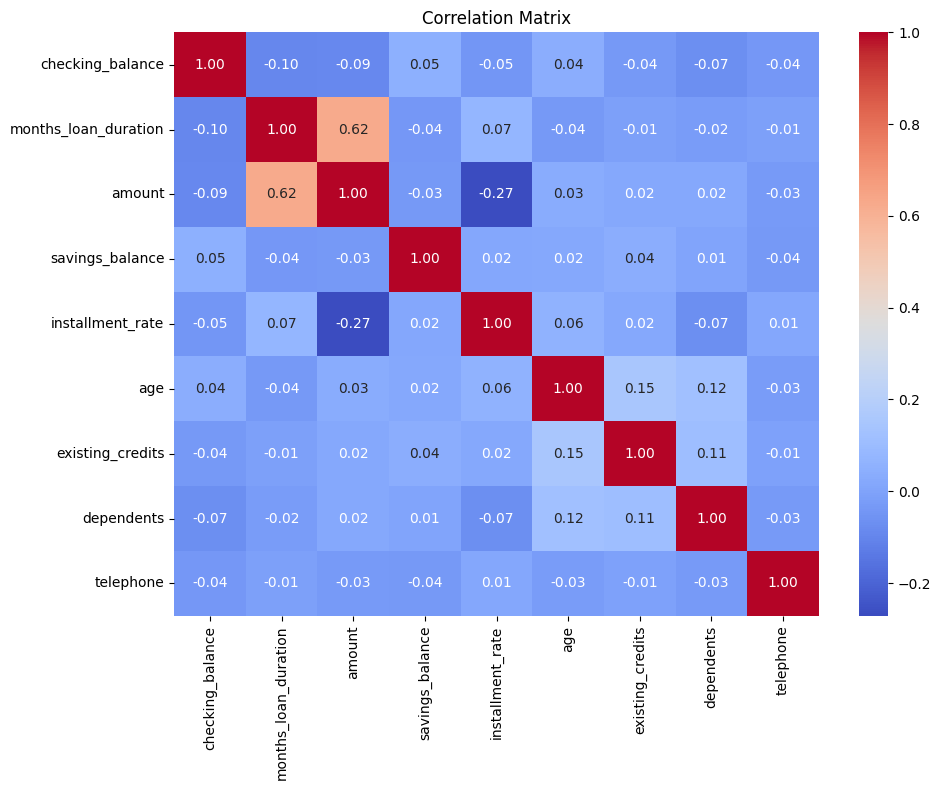

In [14]:
# We geenrate a correlation heatmap that may help reveal columns and features that may be combined
print("📊 Correlation Heatmap:")
plt.figure(figsize=(10, 8))
sns.heatmap(raw_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

There is some correlation between `amount` and `months_loan_duration`. They maay be combined to generate `monthly_payments`.

### 1.3 Feature Engineering Overview

Having learned about the data, I carry out the following preprocessing steps
- I define a function `clean_history` to help with cleaning `residence_history` and `employment_length` and extract time expressed as months for better model generalization
- Handle missing values:
    - For numerical variables such as (`checking_balance`, `savings_balance`, `employment_length`, and `residence_history`), I fill in missing values with `0`. `employment_length` are included here as they become numerical after the initial step above.
    - For categorical columns - `personal_status` is set to `unknown`
    - `telephone`is one-hot encoded as mentioned above to `has_phone` as this retains useful information (e.g., traceability or user verification potential), allowing the model to learn from this, without compromising privacy.

- New columns:
    - I extract `monthly_payment` by combining `amount` and `months_loan_duration`
    - `checking_balance` and `savings_balance` are combined to make `total_cash_balance`, and they are one-hot encoded to flags `has_checking_account` and `has_savings` respectively.
   

Where features were modified or combined, I drop the original features from the dataset.

In [15]:
def clean_history(col):
    """
    Clean the residence_history and employment_month column.
    This function converts the residence history into a numeric format.
    """
    def parse_duration(value):
        if pd.isna(value):
            return 0  # Set NaNs to 0
        value = str(value).strip().lower()

        # Handle years
        if 'year' in value:
            try:
                num = int(value.split()[0])
                return num * 12
            except:
                return 0

        # Handle months
        elif 'month' in value:
            try:
                num = int(value.split()[0])
                return num
            except:
                return 0

        # Handle direct numeric values
        elif value.isdigit():
            return int(value)

        # Catch-all for anything else
        return 0

    return col.apply(parse_duration)

# I create a function to handle cleaning and feature engineering. This function will also be used by the scoring function.
def add_engineered_features(df):
    """
    Add engineered features to the DataFrame.
    This function creates new features based on existing ones to enhance the model's predictive power.
    """
    df = df.copy()

    # Fill missing values for numeric columns
    df['checking_balance'] = df['checking_balance'].fillna(0)
    df['savings_balance'] = df['savings_balance'].fillna(0)
    df['dependents'] = df['dependents'].fillna(0)
    
    # Binning for checking_balance and savings_balance
    bins_checking = [-np.inf, 0, 200, np.inf] 
    labels_checking = ['negative_bal', 'less_than_200', 'over_200'] 
    df['checking_balance_binned'] = pd.cut(df['checking_balance'], bins=bins_checking, labels=labels_checking)

    bins_savings = [-np.inf, 100, 500, 1000, np.inf] 
    labels_savings = ['less_than_100', '100_500', '500_1000', 'over_1000']  
    df['savings_balance_binned'] = pd.cut(df['savings_balance'], bins=bins_savings, labels=labels_savings)

    # 3. Log Transformation for skewed numeric features
    df['log_credit_amount'] = np.log1p(df['amount'])

    # Monthly payment (amount divided by loan duration)
    df['monthly_payment'] = df['amount'] / df['months_loan_duration']
    df['monthly_payment'] = df['monthly_payment'].replace([np.inf, -np.inf], 0).fillna(0)

    # Total available balance
    df['total_cash_balance'] = df['checking_balance'] + df['savings_balance']
    df['total_cash_balance'] = df['total_cash_balance'].fillna(0)

    # Employment status cleaning (you should define `clean_history` function)
    df['employment_length_cleaned'] = clean_history(df['employment_length'])
    
    # Clean residence_history to get duration in months 
    df['residence_in_months'] = clean_history(df['residence_history'])

    # Phone ownership (whether telephone is present)
    df['has_phone'] = (df['telephone'] > 0).astype(int)

    # Credit burden per person (monthly payment divided by dependents)
    df['credit_burden_per_person'] = df['monthly_payment'] / (df['dependents'] + 1)

    # Age groupings (can be helpful for credit risk models)
    df['age_group'] = pd.cut(df['age'], bins=[18, 25, 35, 45, 55, 65, np.inf], 
                             labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    
    # onehot encode categorical variables
    categorical_cols = ['credit_history', 'purpose', 'personal_status', 'other_debtors', 
                        'installment_plan', 'housing', 'property', 'job', 'foreign_worker', 
                        'gender', 'age_group', 'checking_balance_binned', 'savings_balance_binned']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=False, dummy_na=True,dtype=int)

    # Remove original columns
    df.drop(columns=['telephone', 'amount', 'months_loan_duration', 'checking_balance', 
                     'savings_balance', 'employment_length', 'dependents', 'age', 'residence_history'], inplace=True)

    return df

In [16]:
# Apply the feature engineering function to our dataset
df = add_engineered_features(raw_df)

In [17]:
# Explore the new dataframe and Check the new columns
df.head()

,installment_rate,existing_credits,default,log_credit_amount,monthly_payment,total_cash_balance,employment_length_cleaned,residence_in_months,has_phone,credit_burden_per_person,...,age_group_nan,checking_balance_binned_negative_bal,checking_balance_binned_less_than_200,checking_balance_binned_over_200,checking_balance_binned_nan,savings_balance_binned_less_than_100,savings_balance_binned_100_500,savings_balance_binned_500_1000,savings_balance_binned_over_1000,savings_balance_binned_nan
0,4,2,0,7.064759,194.833333,-43.0,156,72,1,97.416667,...,0,1,0,0,0,1,0,0,0,0
1,2,1,1,8.691483,123.979167,164.0,24,5,0,61.989583,...,0,0,1,0,0,1,0,0,0,0
2,2,1,0,7.648263,174.666667,24.0,60,48,0,58.222222,...,0,1,0,0,0,1,0,0,0,0
3,2,1,0,8.972464,187.666667,-23.0,60,156,0,62.555556,...,0,1,0,0,0,1,0,0,0,0
4,3,2,1,8.491055,202.916667,20.0,36,156,0,67.638889,...,0,1,0,0,0,1,0,0,0,0


In [18]:
# Quick glance of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 75 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   installment_rate                       1000 non-null   int64  
 1   existing_credits                       1000 non-null   int64  
 2   default                                1000 non-null   int64  
 3   log_credit_amount                      1000 non-null   float64
 4   monthly_payment                        1000 non-null   float64
 5   total_cash_balance                     1000 non-null   float64
 6   employment_length_cleaned              1000 non-null   int64  
 7   residence_in_months                    1000 non-null   int64  
 8   has_phone                              1000 non-null   int64  
 9   credit_burden_per_person               1000 non-null   float64
 10  credit_history_critical                1000 non-null   int64  
 11  credi

In [19]:
# select dependent and independent variables
X = df.drop(target, axis=1)
y = df[target]

In [20]:
# Set aside 20% of the dataset as test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=21)

### Model Training Step
I will be prioritizing `recall` during model trainig as this project is in credit risk modelling and we are interested in predicting likelihood of default. Recall helps us minimize minimize false negatives which would otherwise lead to losses.

Logistic Regression: 0.3457 (± 0.0980)
KNN: 0.2346 (± 0.0428)
Decision Tree: 0.3519 (± 0.0736)
Random Forest: 0.2729 (± 0.0482)
XGBoost: 0.4298 (± 0.0541)


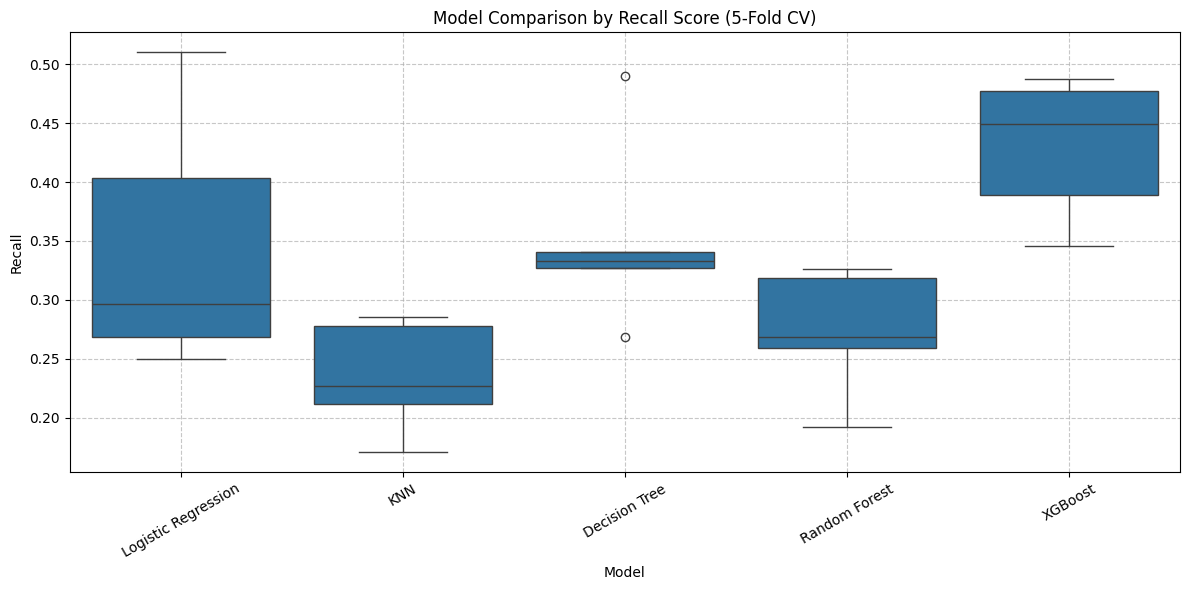

In [21]:
# Define models to evaluate
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# Prepare cross-validation and scoring
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
scoring = 'recall'

# Evaluate models
results = []
model_names = []

for name, model in models:
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.extend(zip([name]*len(cv_scores), cv_scores))
    print(f"{name}: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

# Convert results to DataFrame for plotting
results_df = pd.DataFrame(results, columns=['Model', 'Recall'])

#  plot comparison
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='Recall', data=results_df)
plt.title('Model Comparison by Recall Score (5-Fold CV)')
plt.xticks(rotation=30)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

All model types report low prediction recall perfromance, The XGBoost classifier model shows the best performance followed closely by the Decision Tree model..
I will tune the hyperparameters to try to improve model performance.

In [22]:
# Compute scale_pos_weight ensuring the model pays more attention to the minority class
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Employ Grid Search with cross_validation for to find best estimator
# here we define the parameter space to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.5, 0.6, 0.8],
}

model = XGBClassifier(booster= 'gbtree', scale_pos_weight=scale_pos_weight, random_state=seed)

# perform grid search 
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Replace model with best estimator
model = grid_search.best_estimator_

# Get model predictions on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Recall Score: 0.6125


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       140
           1       0.55      0.58      0.56        60

    accuracy                           0.73       200
   macro avg       0.68      0.69      0.68       200
weighted avg       0.74      0.73      0.73       200

ROC AUC Score: 0.7241666666666666


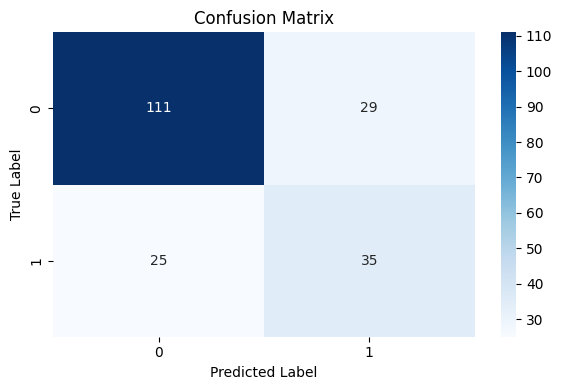

In [23]:
# Use evaluation metrics to compare model performance against ground truth
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Plot confusion matrix with labels
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt="d", cmap="Blues", 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

##### Overall Performance
I set out prioritising  recall to ensure the model minimises losses through false negatives. The overall performance shows:
- Accuracy: 73% — the model correctly predicts 73 out of 100 cases,

- ROC AUC Score: 0.724 — this shows the model has moderate ability to distinguish between the two classes (0 and 1).

##### Class-wise Performance
- Class 0 (majority class)

    - Precision: 0.82 — when the model predicts class 0, it's correct 82% of the time.

    - Recall: 0.79 — it identifies 79% of actual class 0 instances.

    - F1-score: 0.80 — good balance between precision and recall.
     The model performs well on the non-default or good class.

- Class 1 (minority class)

    - Precision: 0.55 — only 55% of predicted class 1 instances are correct.

    - Recall: 0.58 — the model identifies just 58% of true class 1 cases.

    - F1-score: 0.56 — performance is considerably lower than for class 0.
    The model also performs better than the baseline with a recall of 58% as against 42.98% (± 5.41) thanks to the hyperparameter tuning employed.

The model performs reasonably well overall but shows significant imbalance in performance between the two classes despie the training taking into account this imbalance.The model could benefit from further techniques like overesampling to help further prioritise the target class

#### Feature Importance

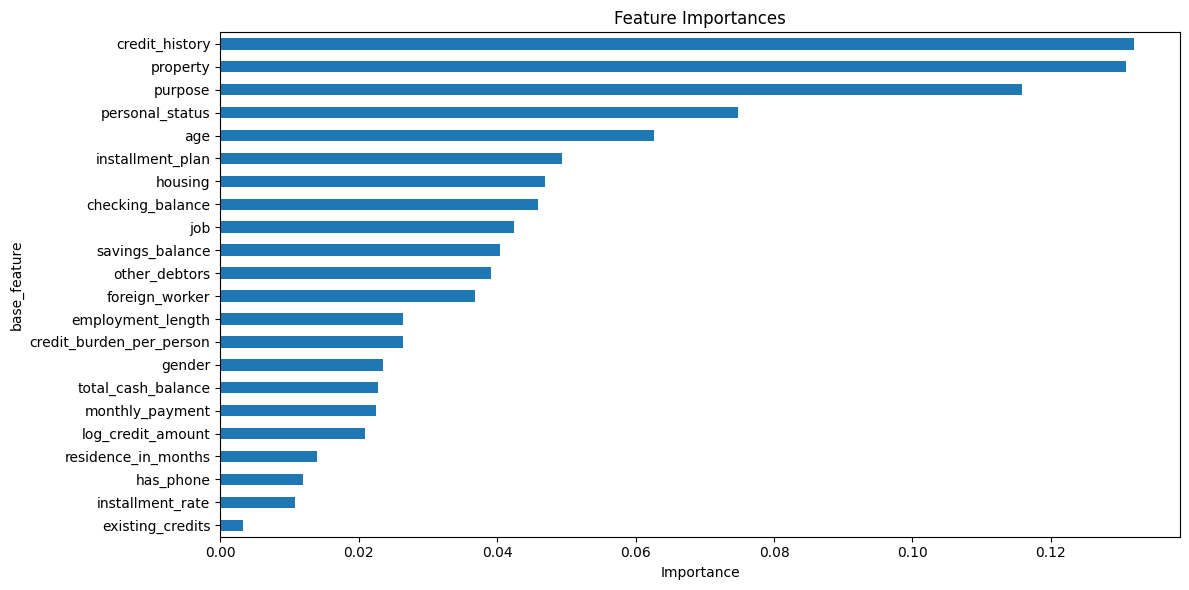

In [24]:
importances = model.feature_importances_
feature_names = X_train.columns

# Create a mapping from dummy columns to their original categorical column
dummy_to_base = {}

base_columns = raw_df.select_dtypes(include=['object']).columns
base_columns.drop(['residence_history', 'employment_length']) # drop 'residence_history', 'employment_length' as they arent true categorical columns
base_columns = base_columns.append(pd.Index(['savings_balance', 'checking_balance', 'age'])) # I tack on 'savings_balance', 'checking_balance' and 'age'

for col in feature_names:
    matched = False
    for cat_col in base_columns:
        if col.startswith(cat_col + '_'):
            dummy_to_base[col] = cat_col
            matched = True
            break
    if not matched:
        dummy_to_base[col] = col  # numerical or unchanged column

# Create DataFrame of importances
feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'base_feature': [dummy_to_base[f] for f in feature_names],
    'importance': importances
})

# Aggregate importances by original column
grouped_importance = (
    feat_importance_df
    .groupby('base_feature')['importance']
    .sum()
    .sort_values(ascending=True)
)

# Filter out zero-importance features
grouped_importance = grouped_importance[grouped_importance > 0]

# Plot
grouped_importance.plot(kind='barh', figsize=(12,6), title="Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

This chart helps us understand the contribution of various features/columns to the model's performance and we can see that `property`, `credit_history`, `purpose`, `checking_balance` and `housing` contribute the most to the model's predictions.

In [25]:
# save current model
joblib.dump(model, 'assets/model_xgb.joblib')

# save columns used in training
feature_columns = X_train.columns.to_list()
joblib.dump(feature_columns, 'assets/feature_columns.pkl')

['assets/feature_columns.pkl']

#### Scoring Function for Model Inference

In [ ]:
def score_customers(
    new_data: Union[dict, List[dict], pd.DataFrame],
    features_file_path: str = None,
    model_checkpoint_path: str = None
) -> Union[int, List[int], pd.Series]:
    """
    Predicts default status for one or more customers using the trained XGBoost model.

    Args:%
        new_data (dict | List[dict] | pd.DataFrame): Customer data (single or multiple rows).
        features_file_path (str, optional): Path to pickled feature column list.
        model_checkpoint_path (str, optional): Path to joblib-saved model.

    Returns:
        int | List[int] | pd.Series: Prediction(s) (0 = no default, 1 = default).
    """
    
    if features_file_path is None:
        features_file_path = 'assets/feature_columns.pkl'
    if model_checkpoint_path is None:
        model_checkpoint_path = 'assets/model_xgb.joblib'

    # Handle single dictionary input
    if isinstance(new_data, dict):
        new_data = pd.DataFrame([new_data])
    elif isinstance(new_data, list):
        new_data = pd.DataFrame(new_data)
    elif isinstance(new_data, pd.DataFrame):
        new_data = new_data.copy()
    else:
        raise ValueError("Input must be a dict, list of dicts, or DataFrame.")

    # Drop 'Unnamed: 0' if present
    if 'Unnamed: 0' in new_data.columns:
        new_data = new_data.drop(columns='Unnamed: 0')

    # Load feature columns and model
    feature_columns = joblib.load(features_file_path)
    model = joblib.load(model_checkpoint_path)

    # Feature engineering
    data = add_engineered_features(new_data)

    # Ensure all required features are present
    for col in feature_columns:
        if col not in data.columns:
            data[col] = 0
    data = data[feature_columns]

    # Predict
    predictions = model.predict(data)

    # Return a single prediction if input was a single record
    return int(predictions[0]) if len(predictions) == 1 else predictions

In [32]:
# Test score a new customer function
sample_data_a = {
    'Unnamed: 0': 1,
    'checking_balance': 150.0,
    'months_loan_duration': 36,
    'credit_history': 'critical',
    'purpose': 'car (new)',
    'amount': 5000,
    'savings_balance': 200.0,
    'employment_length': '2 years',
    'installment_rate': 3,
    'personal_status': None,
    'other_debtors': 'none',
    'residence_history': '5 years',
    'property': 'real estate',
    'age': 45,
    'installment_plan': 'none',
    'housing': 'own',
    'existing_credits': 2,
    'dependents': 0,
    'telephone': 1234567890,
    'foreign_worker': 'yes',
    'job': 'skilled employee',
    'gender': 'male'
}

sample_data_b = {
    'Unnamed: 0': 0,
    'checking_balance': None,
    'months_loan_duration': 1,
    'credit_history': 'delayed',
    'purpose': 'education',
    'amount': 500000,
    'savings_balance': None,
    'employment_length': None,
    'installment_rate': 4,
    'personal_status': 'single',
    'other_debtors': 'none',
    'residence_history': '0 years',
    'property': 'other',
    'age': 30,
    'installment_plan': 'none',
    'housing': 'rent',
    'existing_credits': 1,
    'dependents': 4,  
    'telephone': None,  
    'foreign_worker': 'no',
    'job': 'unskilled resident', 
    'gender': 'female'
}

print(f"Prediction for A: {score_customers(sample_data_a)}")
print(f"Prediction for B: {score_customers(sample_data_b)}")

Prediction for A: 0
Prediction for B: 1
